### Question 7-13 Experiments with Adaptive Boosting.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_dataset = np.loadtxt("hw3_train.txt")
test_dataset = np.loadtxt("hw3_test.txt")

x_train, y_train = train_dataset[:,:2], train_dataset[:,2]
x_test, y_test = test_dataset[:,:2], test_dataset[:,2]

In [3]:
print(x_train.shape, x_test.shape)

(100, 2) (1000, 2)


In [4]:
def visualization(x, y):
    for i in range(x.shape[0]):
        if y[i] == 1:
            plt.scatter(x[i,0], x[i,1], marker="o")
        else:
            plt.scatter(x[i,0], x[i,1], marker="x")

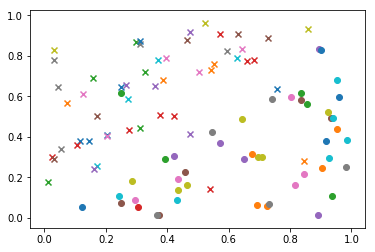

In [5]:
visualization(x_train, y_train)

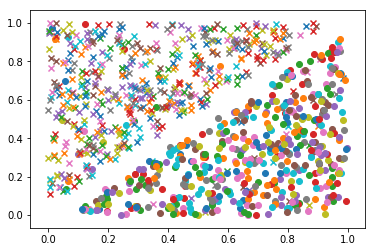

In [6]:
visualization(x_test, y_test)

In [7]:
def decision_stump(x,y,w):

    E = 1
    best_feature = 0
    best_s = 0
    best_theta = 0
    err_index = None
    
    # sample (x,y) using w
    w = w/sum(w)
    length = y.shape[0]
    index = np.arange(length)
    seleted_index = np.random.choice(index, size=length, replace=True, p=w)
    sample_x, sample_y = x[seleted_index], y[seleted_index] 
    
    # 遍历x的所有维度，和所有的可能切分，找到一个最好的划分位置
    for i in range(sample_x.shape[1]):
        original_feature = sample_x[:,i]
        feature = np.sort(original_feature)
        r_shift_feature = np.append(feature[1:], feature[-1]+1)
        split = 0.5 * (feature + r_shift_feature)
        split = np.append(np.array(split[0]-1), split)
        
        for s in split:

            y_pre = [1 if f>s else -1 for f in original_feature]
            E_in = np.sum(y_pre!=sample_y)/length
            
            if E_in<E or E_in>1-E :
                best_s = s
                best_feature = i
                
                if E_in<E:
                    best_theta = 0
                    E = E_in
                else:
                    best_theta = 1
                    E = 1 - E_in
            
    
    # use the best found model, and eveluate it on all x,y data rather than sample data
    feature = x[:, best_feature]
    
    if best_theta==0 :
        y_pre = [1 if f>best_s else -1 for f in feature]
    else:
        y_pre = [1 if f<best_s else -1 for f in feature]
        
    E_in = np.sum(y_pre!=y)/length
    err_index = np.where((y_pre-y)!=0)[0]
    
    return best_s, best_feature, best_theta, E, E_in, err_index

In [8]:
def evaluate_model(models, x, y):
    E_ins = []
    data_len = y.shape[0]
    preds = np.zeros(data_len)
    
    # eveluate all models (number of models can be 1)
    for s, feature, theta, alpha in models:
        pred = np.array([1 if i>s else -1 for i in x[:,feature]])
        if theta==1 : 
            pred = pred * (-1)
        preds += pred * alpha

    final_preds = [1 if i>0 else -1 for i in preds]
    E_in = float(np.sum(final_preds!=y)/data_len)
       
    return E_in

In [9]:
def adaboost_decision_stump(x,y,x_test,y_test,T):

    # lists to store trained decision trees
    models = []
    E_single_model_sample_data = []
    E_single_model_in = []
    E_all_models_in = []
    E_single_model_out = []
    E_all_models_out = [] 
    alphas = []
    ws = [] # 统计不同数据点的权重的变化情况
    
    # sampling weights
    data_len = y.shape
    w = np.ones(data_len)/data_len
    
    for i in range(T):
      
        # train a decision tree
        s, feature, theta, E, E_in, err_index = decision_stump(x,y,w)
        # s, feature, theta, E_in, err_index = decision_stump(x,y,w)
        delta = np.sqrt((1-E_in)/E_in)
        alpha = np.log(delta)
        model = [s, feature, theta, alpha]
        models.append(model)
        alphas.append(alpha)
        ws.append(sum(w))
        E_single_model_sample_data.append(E)
        
        # use delta to update w
        w = np.array([i*alpha for i in w if i in err_index or i/alpha])
        
        # eveluate the last model on training data
        # E_in_last = evaluate_model([model], x, y)
        # E_single_model_in.append(E_in_last)
        E_single_model_in.append(E_in)
        
        # eveluate all models on training data
        E_in_all = evaluate_model(models, x, y)
        E_all_models_in.append(E_in_all)
        
        # eveluate the last model on test data
        E_out_last = evaluate_model([model], x_test, y_test)
        E_single_model_out.append(E_out_last)
        
        # eveluate the last model on test data
        E_out_all = evaluate_model(models, x_test, y_test)
        E_all_models_out.append(E_out_all)
        
    
    return E_single_model_sample_data, E_single_model_in, E_all_models_in, E_single_model_out, E_all_models_out, alphas, ws, models

In [10]:
E_single_model_sample_data, E_single_model_in, E_all_models_in, E_single_model_out, E_all_models_out, alphas, ws, models = adaboost_decision_stump(x_train, y_train, x_test, y_test, 300)

In [11]:
# 画出多个模型共同决定的分界面
def plot_result(models):
    
    n = 50
    
    x_1 = np.linspace(0, 1, n)
    x_2 = np.linspace(0, 1, n)
    x_1, x_2 = np.meshgrid(x_1, x_2)
    x_1 = np.reshape(x_1, (n**2,1))
    x_2 = np.reshape(x_2, (n**2,1))
    x = np.concatenate([x_1, x_2], axis=1)
    
    preds = np.zeros(n**2)
    for s, feature, theta, alpha in models:
        pred = np.array([1 if i>s else -1 for i in x[:,feature]])
        if theta==1 : 
            pred = pred * (-1)
        preds += pred * alpha
        
    final_preds = [1 if i>0 else -1 for i in preds]    
    
    visualization(x, final_preds)  

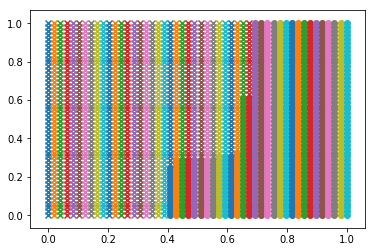

In [12]:
# 画出分界面
plot_result(models)

#### 7. Plot a figure for t versus Ein(gt). What is Ein(g1) and what is α1?

In [13]:
E_in_g1=E_single_model_in[0]
alpha_1 = alphas[0]
print("E_in(g1) = %f, alpha_1 = %f" %(E_in_g1, alpha_1))

E_in(g1) = 0.260000, alpha_1 = 0.522984


#### 8. From the figure in the previous question, should Ein(gt) be decreasing or increasing? Write down your observations and explanations.

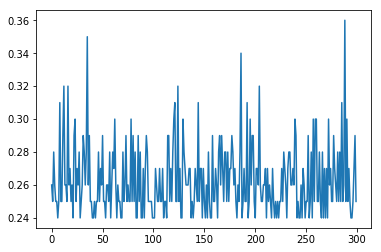

In [15]:
plt.plot(E_single_model_in);

#### 9. Plot a figure for t versus Ein(Gt), where Gt(x) = sign(􏰉tτ=1 ατ gτ (x)). That is, G = GT . What is Ein(G)?

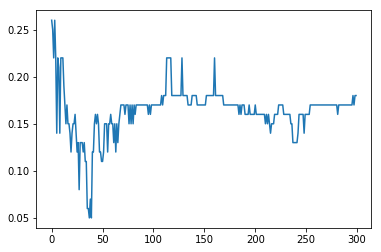

In [16]:
plt.plot(E_all_models_in);

- 整体上呈现下降的趋势，当循环次数超过一定值时模型的loss不再下降
- 在局部会有小的反复

#### 10. (*)Plot a figure for t versus Ut, where Ut is sum of un . What is U2 and what is UT?

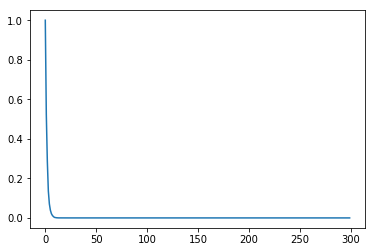

In [17]:
plt.plot(ws);

#### 11. (*) Plot a figure for t versus εt. What is the minimum value of εt?

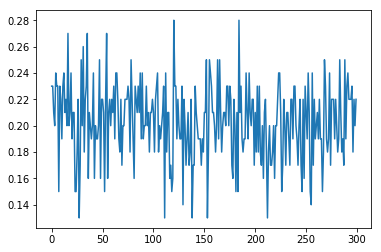

In [18]:
plt.plot(E_single_model_sample_data);

#### 12. (*) Plot a figure for t versus Eout(gt) estimated with the test set. What is Eout(g1)?

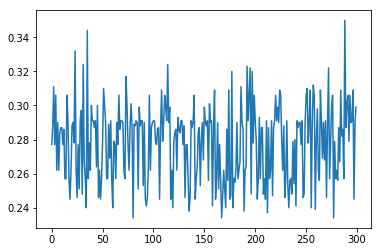

In [19]:
plt.plot(E_single_model_out);

#### 13. (*) Plot a figure for t versus Eout(Gt) estimated with the test set. What is Eout(G)?

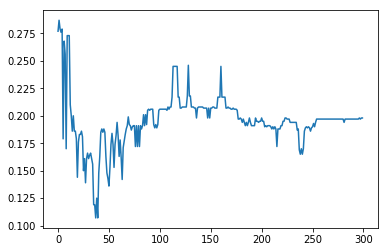

In [20]:
plt.plot(E_all_models_out);